In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/"
!ls "drive/My Drive/"

Mounted at /content/drive
1.avi  2.avi


In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from matplotlib import pylab as plt


Cap = cv2.VideoCapture(data_path+'videos/1.avi')

width  = int(Cap.get(cv2.CAP_PROP_FRAME_WIDTH))  
height = int(Cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(Cap.get(cv2.CAP_PROP_FPS))
fnum = int(Cap.get(cv2.CAP_PROP_FRAME_COUNT))

print('Information about video file:')
print('width => ', width)
print('height => ', height)
print('fps => ', fps)
print('num frames => ', fnum)

out_video_name = 'outpy.avi'
out_video_m = cv2.VideoWriter(out_video_name,
                            cv2.VideoWriter_fourcc('M','J','P','G'),
                            fps, (width,height))

Information about video file:
width =>  1280
height =>  720
fps =>  16
num frames =>  507


In [7]:
def get_frame(frame_number,Cap):
    Cap.set(1,frame_number)
    ret, frame = Cap.read()
    return frame


for _fn in range(fnum):
    if _fn==8:
        break  
    frame = get_frame(_fn,Cap)
    frame_tmp = cv2.resize(frame, (430,240))
    frame_tmp = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_tmp)
    plt.show()
    plt.pause(0.001)    
    
clear_output()

In [8]:
firstframe = get_frame(0,Cap)

cv2.imwrite('firstframe.png',firstframe)

# from google.colab import files
# files.download('firstframe.png')

True

Firstframe image-in-image


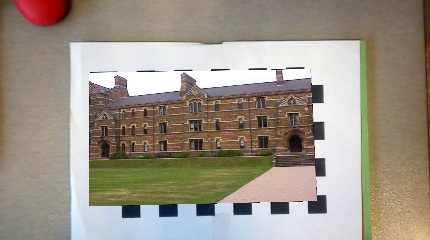

In [9]:
def put_img_in_img(img1, img2, rect):

    rows,cols,ch = img1.shape

    # rect is hard coded the 4 corner points on the reference image to be fitted.
    # now that we have our rectangle of points, let's compute
    # the width of our new image
    (tl, tr, bl, br) = rect

    widthA = (tr[0] - tl[0])
    widthB = (br[0] - bl[0])
    # ...and now for the height of our new image
    heightA = (bl[1] - tl[1])
    heightB = (br[1] - tr[1])
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # construct our destination points which will be used to
    # map the screen to a top-down, "birds eye" view
    dst = np.array([[0, 0],[maxWidth-1, 0],
                    [0, maxHeight-1],[maxWidth-1, maxHeight-1]], dtype = "float32")
    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(dst, rect)
    img2 = cv2.resize(img2, (maxWidth,maxHeight))
    dst = cv2.warpPerspective(img2, M, (cols,rows))

    img2gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(img2gray, 0, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    img1_new = cv2.bitwise_and(img1,img1,mask = mask_inv)
    # dst = cv2.bitwise_and(dst,dst,mask = mask)

    # Just for Debugging the output.
    final = cv2.add(dst, img1_new)
    return final


# Load two images 
firstframe = get_frame(0,Cap)
base_img = firstframe
new_img = cv2.imread(data_path+'images/building1.jpg') 
# new_img = cv2.imread(data_path+'images/room.jpg')

# Hard coded the 4 corner points on the reference image to be fitted.
rect = np.float32([[265, 218], [924, 207],
                  [265, 618], [943, 602]])

# rect = np.float32([[200, 125], [1090, 120],
#                   [210, 717], [1100, 717]])       
final = put_img_in_img(base_img, new_img, rect)
    
print('Firstframe image-in-image')
cv2_imshow(cv2.resize(final, (430,240)))

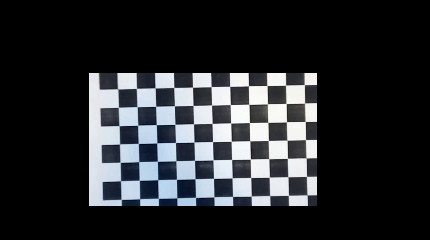

In [10]:
(tl, tr, bl, br) = rect
maxWidth = max(int(tr[0] - tl[0]), int(br[0] - bl[0]))
maxHeight = max(int(bl[1] - tl[1]), int(br[1] - tr[1]))

small_image = firstframe[int(tl[1]):int(tl[1]+maxHeight),
                        int(tl[0]):int(tl[0]+maxWidth)]
mask = np.zeros((firstframe.shape[0],firstframe.shape[1]), dtype=np.uint8)
mask [int(tl[1]):int(tl[1]+maxHeight),
      int(tl[0]):int(tl[0]+maxWidth)] = 255
frame_region = cv2.bitwise_and(firstframe,firstframe,mask = mask)
cv2_imshow(cv2.resize(frame_region, (430,240)))

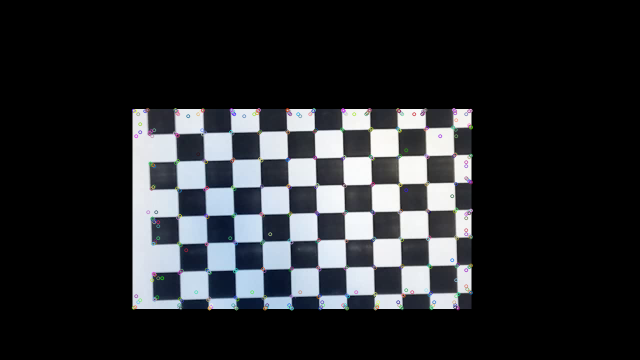

In [11]:
gray= cv2.cvtColor(frame_region,cv2.COLOR_BGR2GRAY)
detector = cv2.xfeatures2d_HarrisLaplaceFeatureDetector.create()
kp = detector.detect(gray,None)
img=cv2.drawKeypoints(frame_region,kp,None)

cv2_imshow(cv2.resize(img, (640,360)))
# cv2_imshow(img)

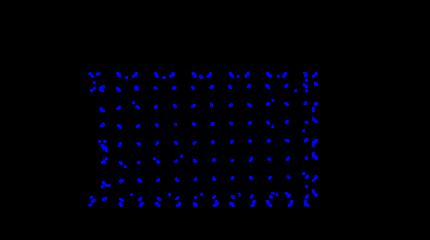

In [12]:
timg = np.zeros_like(img,dtype=np.uint8)
kp_list = []
for _cnt,_k in enumerate(kp):
  # print(_k.pt)
  timg = cv2.circle(timg,(int(_k.pt[0]),int(_k.pt[1])),5,[255,0,0],-1)
  kp_list.append([_k.pt[0],_k.pt[1]])
  # if _cnt==150:
  #   break

kp_list = np.array(kp_list).reshape(-1,1,2).astype(np.float32)
cv2_imshow(cv2.resize(timg, (430,240)))

In [13]:
def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography



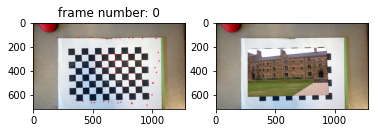

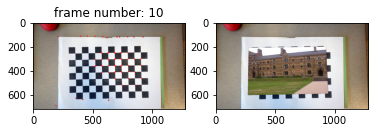

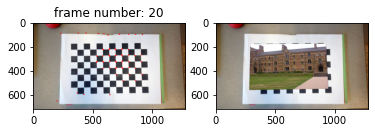

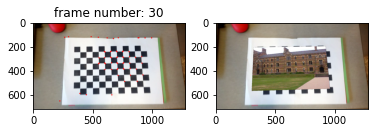

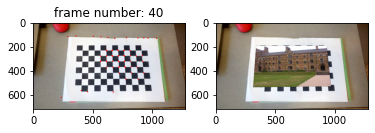

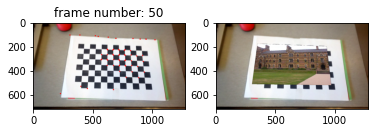

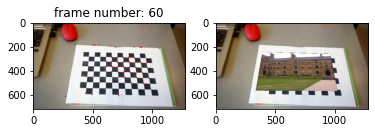

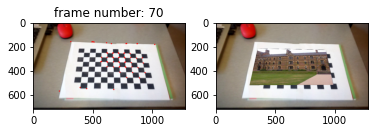

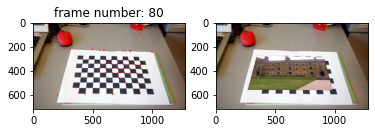

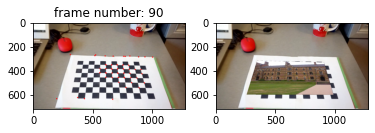

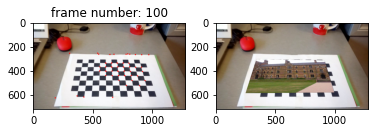

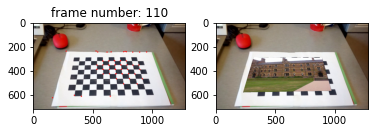

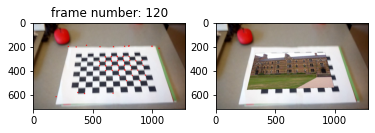

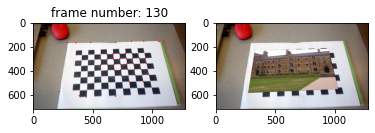

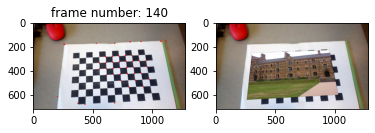

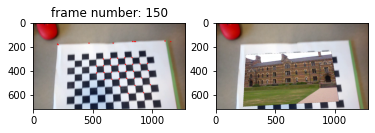

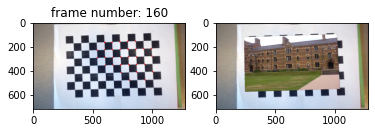

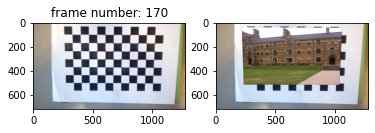

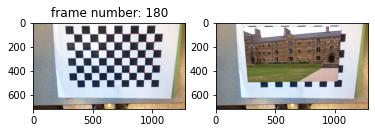

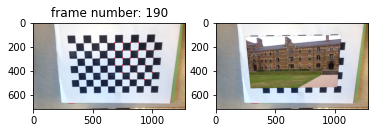

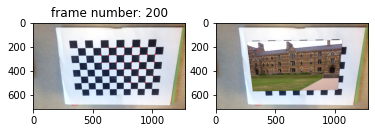

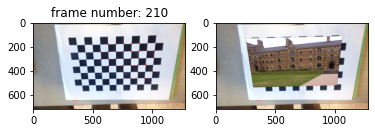

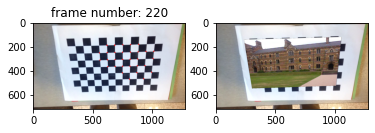

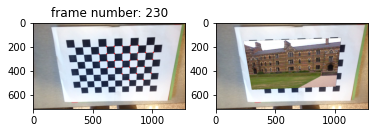

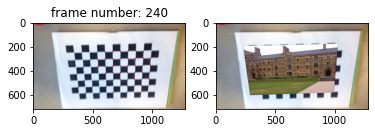

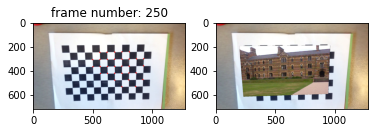

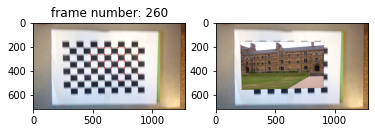

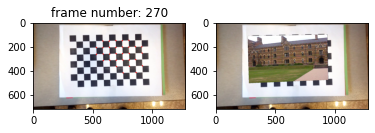

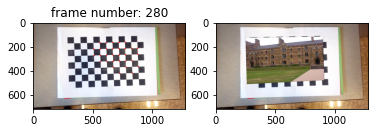

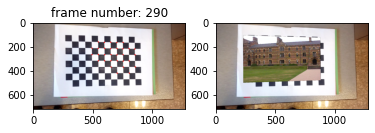

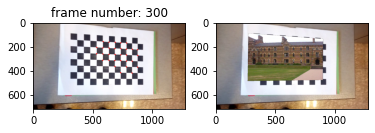

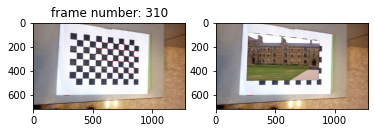

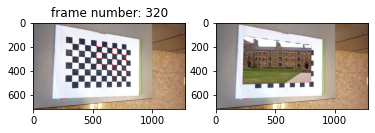

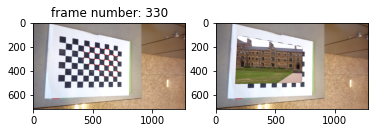

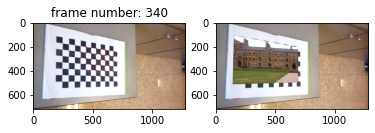

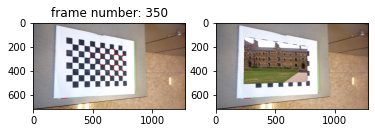

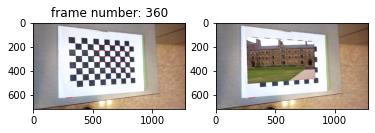

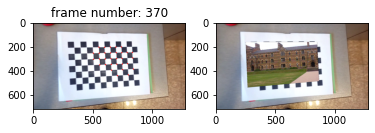

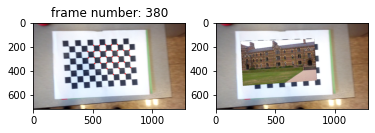

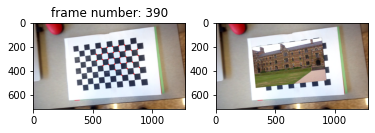

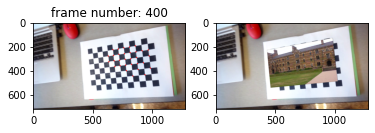

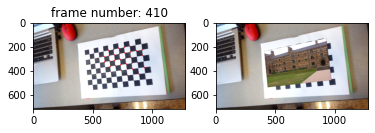

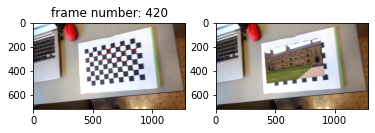

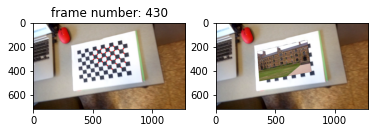

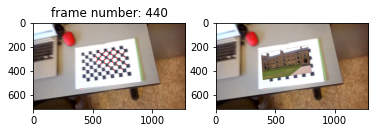

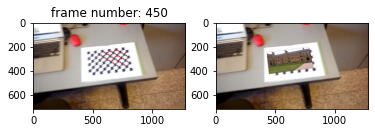

In [14]:
out_video = out_video_m
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

old_gray = cv2.cvtColor(frame_region, cv2.COLOR_BGR2GRAY)
pts = rect.reshape(-1,1,2)
# p0 = kp_list

#############feature extraction from first frame##################  

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

###############################

# Create some random colors
# color = np.random.randint(0,255,(500,3))
     
for _frm in range(0,fnum-50):
    frame = get_frame(_frm,Cap)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    p0r, _st, err = cv2.calcOpticalFlowPyrLK(frame_gray, old_gray, p1, None, **lk_params)
    d = abs(p0-p0r).reshape(-1, 2).max(-1)
    good = d < 2
    # Select good points
    good_new = p1[st.squeeze()==1]
    good_old = p0[st.squeeze()==1]

    src_pts = good_old.reshape(-1,1,2)
    dst_pts = good_new.reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    try:
        dst = cv2.perspectiveTransform(pts,M).reshape(-1,2)
        final = put_img_in_img(frame, new_img, dst)
        error_occurs = False
    except:
        dst = pts.reshape(-1,2)
        final = put_img_in_img(frame, new_img, dst)

    ## write frames to file
    out_video.write(final)


    # draw keypoints
    for new in good_new:
        a,b = new.ravel()
        frame = cv2.circle(frame,(a,b),5,[0,0,255],-1)
    

    # show some frames
    if (_frm%10)==0:
        frame_tmp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        final_tmp = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
        plt.subplot(1,2,1)
        plt.title('frame number: '+str(_frm))
        plt.imshow(frame_tmp)
        plt.subplot(1,2,2)
        plt.imshow(final_tmp)
        plt.show()
        plt.pause(0.001)

######################################
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    pts = dst.reshape(-1,1,2)


# Cap.release()
out_video.release()

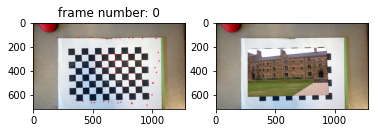

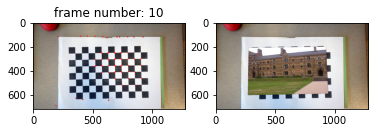

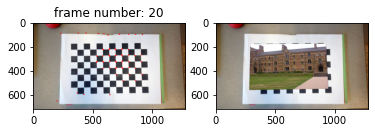

New codes applied.


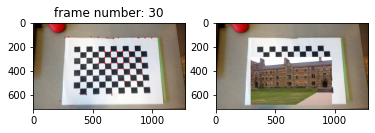

New codes applied.


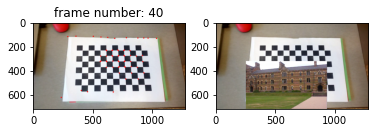

New codes applied.


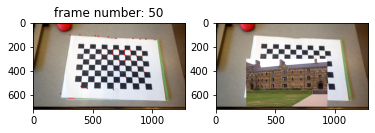

In [15]:
out_video = out_video_m
error_occurs = False
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

old_gray = cv2.cvtColor(frame_region, cv2.COLOR_BGR2GRAY)
pts = rect.reshape(-1,1,2)
# p0 = kp_list

#############feature extraction from first frame##################  

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

###############################

# Create some random colors
# color = np.random.randint(0,255,(500,3))
     
for _frm in range(0,fnum-450):
    frame = get_frame(_frm,Cap)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    p0r, _st, err = cv2.calcOpticalFlowPyrLK(frame_gray, old_gray, p1, None, **lk_params)
    d = abs(p0-p0r).reshape(-1, 2).max(-1)
    good = d < 2
    # Select good points
    good_new = p1[st.squeeze()==1]
    good_old = p0[st.squeeze()==1]

    src_pts = good_old.reshape(-1,1,2)
    dst_pts = good_new.reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    try:
        dst = cv2.perspectiveTransform(pts,M).reshape(-1,2)
        final = put_img_in_img(frame, new_img, dst)
        error_occurs = False
    except:
        error_occurs = True

    if error_occurs or (((_frm%10)==0) and (_frm>20)):


        method = cv2.TM_SQDIFF_NORMED
        result = cv2.matchTemplate(small_image, frame, method)
        mn,_,mnLoc,_ = cv2.minMaxLoc(result)
        MPx,MPy = mnLoc
        trows,tcols = small_image.shape[:2]
        dst = np.float32([[MPx,MPy],[MPx+tcols,MPy],
                         [MPx,MPy+trows],[MPx+tcols,MPy+trows]])
        final = put_img_in_img(frame, new_img, dst)
        print("New codes applied.")

    ## write frames to file
    out_video.write(final)


    # draw keypoints
    for new in good_new:
        a,b = new.ravel()
        frame = cv2.circle(frame,(a,b),5,[0,0,255],-1)
    

    # show some frames
    if (_frm%10)==0:
        frame_tmp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        final_tmp = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
        plt.subplot(1,2,1)
        plt.title('frame number: '+str(_frm))
        plt.imshow(frame_tmp)
        plt.subplot(1,2,2)
        plt.imshow(final_tmp)
        plt.show()
        plt.pause(0.001)

######################################
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    pts = dst.reshape(-1,1,2)


# Cap.release()
out_video.release()